# PHM North America challenge '23

# Offline vibration fingerprint extraction

This notebook constructs the context-sensitive vibration fingerprints from the vibration data that was previously preprocessed in [02_data_processing.ipynb](02_data_processing.ipynb).

# Requirements

To run the offline fingerprint extraction, following requirements must be met:

| Name | Abbreviated | Format | Used for |
|------|-------------|--------|----------|
| Decomposition matrix | $\mathbf{V}$ | $\mathbb{R}^{n\times m}$ | Matrix with preprocessed vibrations that are subsequently disaggregated. $n$ vibration measurements, $m$ frequency bins. In this notebook series, we create 100 separate folds, hence there are 100 decomposition matrices stored in `df_V_train_folds`. |
| Meta data |  | pandas dataframe | Contains for each of the $n$ vibration measurements additional information, such as the vibration measurement direction or the pitting level used in the experiment. Stored in `meta_data_train_folds`. |
| Operational data (included in meta data) | | | Features which indicate in which operating mode the asset is running. Normally, this would be a timeseries independently sampled from the vibration measurements. As in PHM North America, all samples were sampled at static operating conditions, there are $n$ process measurements. | 

In [1]:
%load_ext autoreload
%autoreload 2

from conscious_engie_icare.data.phm_data_handler import CACHING_FOLDER_NAME, fetch_and_unzip_data, \
                                                        load_data, BASE_PATH_HEALTHY, BASE_PATHS_TEST, PITTING_LEVELS, \
                                                        FPATH_DISTANCES
from conscious_engie_icare.nmf_profiling import extract_nmf_per_number_of_component, extract_nmf_incremental, \
                                                derive_df_vib, derive_df_orders
from conscious_engie_icare.viz.viz import illustrate_nmf_components_for_paper, illustrate_nmf_components_interactive
from conscious_engie_icare import distance_metrics
from conscious_engie_icare.normalization import normalize_1
from conscious_engie_icare.util import calculate_roc_characteristics, calc_tpr_at_fpr_threshold, calc_fpr_at_tpr_threshold
from conscious_engie_icare.preprocessing import get_and_preprocess_healthy_data, get_and_preprocess_unhealthy_data
import pickle
import os
from tqdm import tqdm
import glob
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import string
from matplotlib.colors import LogNorm

import kneed
from ipywidgets import interact, Layout
import ipywidgets as widgets
from copy import deepcopy
from matplotlib.gridspec import GridSpec
import re

import matplotlib.patches as patches
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import glob
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ignore convergence warnings (1000 iterations reached by NMF)
import warnings;
warnings.filterwarnings('ignore');

Set `CACHE_RESULTS` to `True` to cache the results of the feature extraction process. This will speed up the notebook execution time in subsequent executions.

In [2]:
recompute = True
df_V_train, meta_data_train, df_data_healthy_test, f = get_and_preprocess_healthy_data(recompute=recompute)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:25<00:00, 11.34it/s]


Load [previously preprocessed](02_data_processing.ipynb) vibration data.

In [3]:
# extract list of frequency band columns for later usage
cols_ = df_V_train.columns
BAND_COLS = cols_[cols_.str.contains('band')].tolist()

## Non-negative matrix factorization (NMF)

Below, we decompose the vibration decomposition matrix $\mathbf{V}$ into a weight matrix $\mathbf{W}$ and a component matrix $\mathbf{H}$ for each of the 100 folds.
We decompose the matrix into up to 40 components, i.e. there are around 4000 different non-negative matrix factorizations performed.
As the cell takes around 20 minutes to execute, we cache the results to avoid re-executing it in subsequent runs.

 > Cell with function that extracts NMF profiles. No interactivity or plots, so just a button to click that starts the extraction.
 
 > Using 20 components now takes 10 minutes. Too long?

In [4]:
RECOMPUTE = True        # only set to True, if NMF should be recomputed
MAX_N_COMPONENTS = 40    # maximum number of components used to recompute

fpath = os.path.join(CACHING_FOLDER_NAME, 'df_nmf_models', f'df_nmf_models.pkl')
if not os.path.exists(fpath) or RECOMPUTE:
    df_nmf_models = extract_nmf_incremental(
        df_V_train, max_n_components=MAX_N_COMPONENTS, timestamps=df_V_train.index, verbose=True)
    os.makedirs(os.path.dirname(fpath), exist_ok=True)
    pickle.dump(df_nmf_models, open(fpath, 'wb'))

else:
    # load data from disk
    fpath = os.path.join(CACHING_FOLDER_NAME, 'df_nmf_models', f'df_nmf_models.pkl')

    df_nmf_models = pickle.load(open(fpath, 'rb'))

Fitting NMF with varying number of components: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:20<00:00,  2.01s/it]


Below, we illustrate the decomposition of the vibration data for the first fold.

- The left plot shows the decomposition matrix $\mathbf{V}$ as it was preprocessed in the previous notebook. Each vibration measurement is represented as a row in the matrix, each column represents an order transformed and normalized bin. We stack the 3 different measurement directions on top of each other, resulting in 645 vibration measurements, corresponding to the 215 measurements in the training set.
- The middle two plots visualize how well the decomposition matrix $\mathbf{V}$ can be approximated. 
    - The top plot illustrates the cumulative explained variance of a principal component analysis (PCA) of the decomposition matrix $\mathbf{V}$. It serves as an indication of an upper bound for how well the signal could be expressed using PCA.
    - The bottom plot illustrates the reconstruction error of the decomposition matrix $\mathbf{V}$ using the NMF components. The reconstruction error is calculated as the Frobenius norm of the difference between the original matrix and the reconstructed matrix.
- The right plot illustrates the component matrix $\mathbf{H}$. Each individual component expresses a different peak. The number of components is determined by how many components in a in parallel running PCA are needed to explain 95% of the variance in the data, corresponding to 5 components in this case.

> Plotting the results for the NMF. Output are consists of two parts: the top two plots are the explained variance ratio of the PCA, the second one is the reconstructione error of the NMF. Below that, the NMF components are plot, the exact number of which is variable. 

> The free options are the fold to plot, as well as the way to determine the number of components (knee point detection, using a minimum variance threshold, or both). The user can also specify the minimum and maximum number of components. If the minimum explained variance is used (or both methods), this threshold can be set as well.

In [5]:
saved_values = illustrate_nmf_components_interactive(df_V_train, df_nmf_models)

interactive(children=(Dropdown(description='How to select the number of components for NMF', layout=Layout(wid…

We utilize across all folds the same number of components. We choose 5 based on the analysis above.

In [6]:
N_COMPONENTS = saved_values['n_components']
COMPONENT_COLUMNS = list(range(N_COMPONENTS))  # used later
model = df_nmf_models[(df_nmf_models.n_components == N_COMPONENTS)].iloc[0]

# Offline vibration fingerprint extraction

The process view is simplified in this particular use case.
In contrast to the industrial dataset, in this dataset there are no timestamps. 
However, we know speed and torque for each measurement. 
Therefore, we merge the fingerprint with the operating mode.
Below we plot the weights of a single measurement from the training set.
All measurement directions (x, y and z) are stacked.

> Interactivity idea: Plot that shows the different fingerprints (user can chose the speed and torque, as well as fold).
> Also include the individual measurements?
> Maybe different kind of visualization so we can show both individual measurements and aggregated fingerprint?

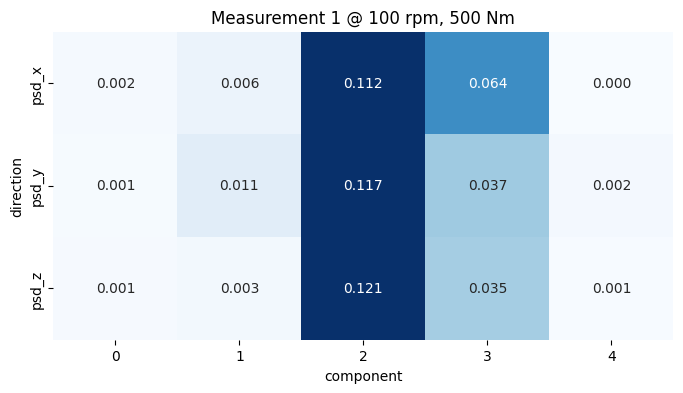

In [7]:
W_train = model.W.reshape(-1, N_COMPONENTS)
df_W_train = pd.DataFrame(W_train)
#display(f'Fold {i}. Shape: {W_train_.shape}')
df_W_train.index = df_V_train.index
df_W_train['direction'] = meta_data_train['direction']

# add operating mode (OM)
df_W_train_with_OM = pd.merge(df_W_train, meta_data_train.drop(columns=['direction']), left_index=True, right_index=True)

# illustrate weights of single measurement 
rpm=100
torque=500
run=1

df_ = df_W_train_with_OM[(df_W_train_with_OM['rotational speed [RPM]']==rpm) &
                          (df_W_train_with_OM['torque [Nm]']==torque) &
                          (df_W_train_with_OM['sample_id']==run)]
df_ = df_.set_index('direction')
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(df_[list(range(N_COMPONENTS))], annot=True, fmt=".3f", ax=ax, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
ax.set_title(f'Measurement {run} @ {rpm} rpm, {torque} Nm');
ax.set_xlabel('component');

A **context-sensitive vibration fingerprint** is the aggregation over all measurements of a given operating mode.
Below, we plot the context-sensitive vibration fingerprint for the same operating mode. 

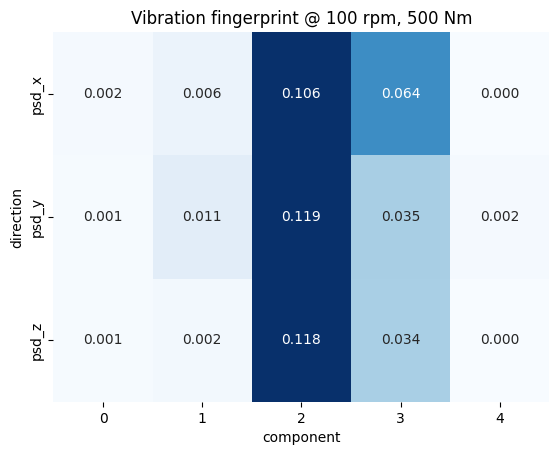

In [8]:
df_ = df_W_train_with_OM[(df_W_train_with_OM['rotational speed [RPM]']==rpm) & (df_W_train_with_OM['torque [Nm]']==torque)]
df_ = df_[list(range(N_COMPONENTS)) + ['direction']].groupby('direction').mean()
fig, ax = plt.subplots()
sns.heatmap(df_, annot=True, fmt=".3f", ax=ax, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
ax.set_title(f'Vibration fingerprint @ {rpm} rpm, {torque} Nm');
ax.set_xlabel('component');

We observe that the vibration fingerprint and the measurement are very similar, due to at least following reasons: 
- As the measurements were taken in a controlled environment, the operating mode is constant for each operating condition.
- There are very few measurements per operating mode. Therefore, the fingerprint is influenced to a high degree by the single measurement.

The vibration fingerprint serves as key component of the context-sensitive anomaly detection.

In what follows we construct the vibration fingerprint for each operating mode in the training set, where we treat each unique combination of speed and torque as a separate operating mode. We then aggregate the fingerprints for each operating mode. The 73 fingerprints are visualized below. Note that the number of fingerprints may vary depending on the fold, as not all operating modes are present in each fold.

> This should be merged with the above, since that allows for the user to plot a specific fingerprint. We can add the option to plot all of them.
Computing them should be done prior to any plotting.

Plotting fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [01:18<00:00,  1.03s/it]


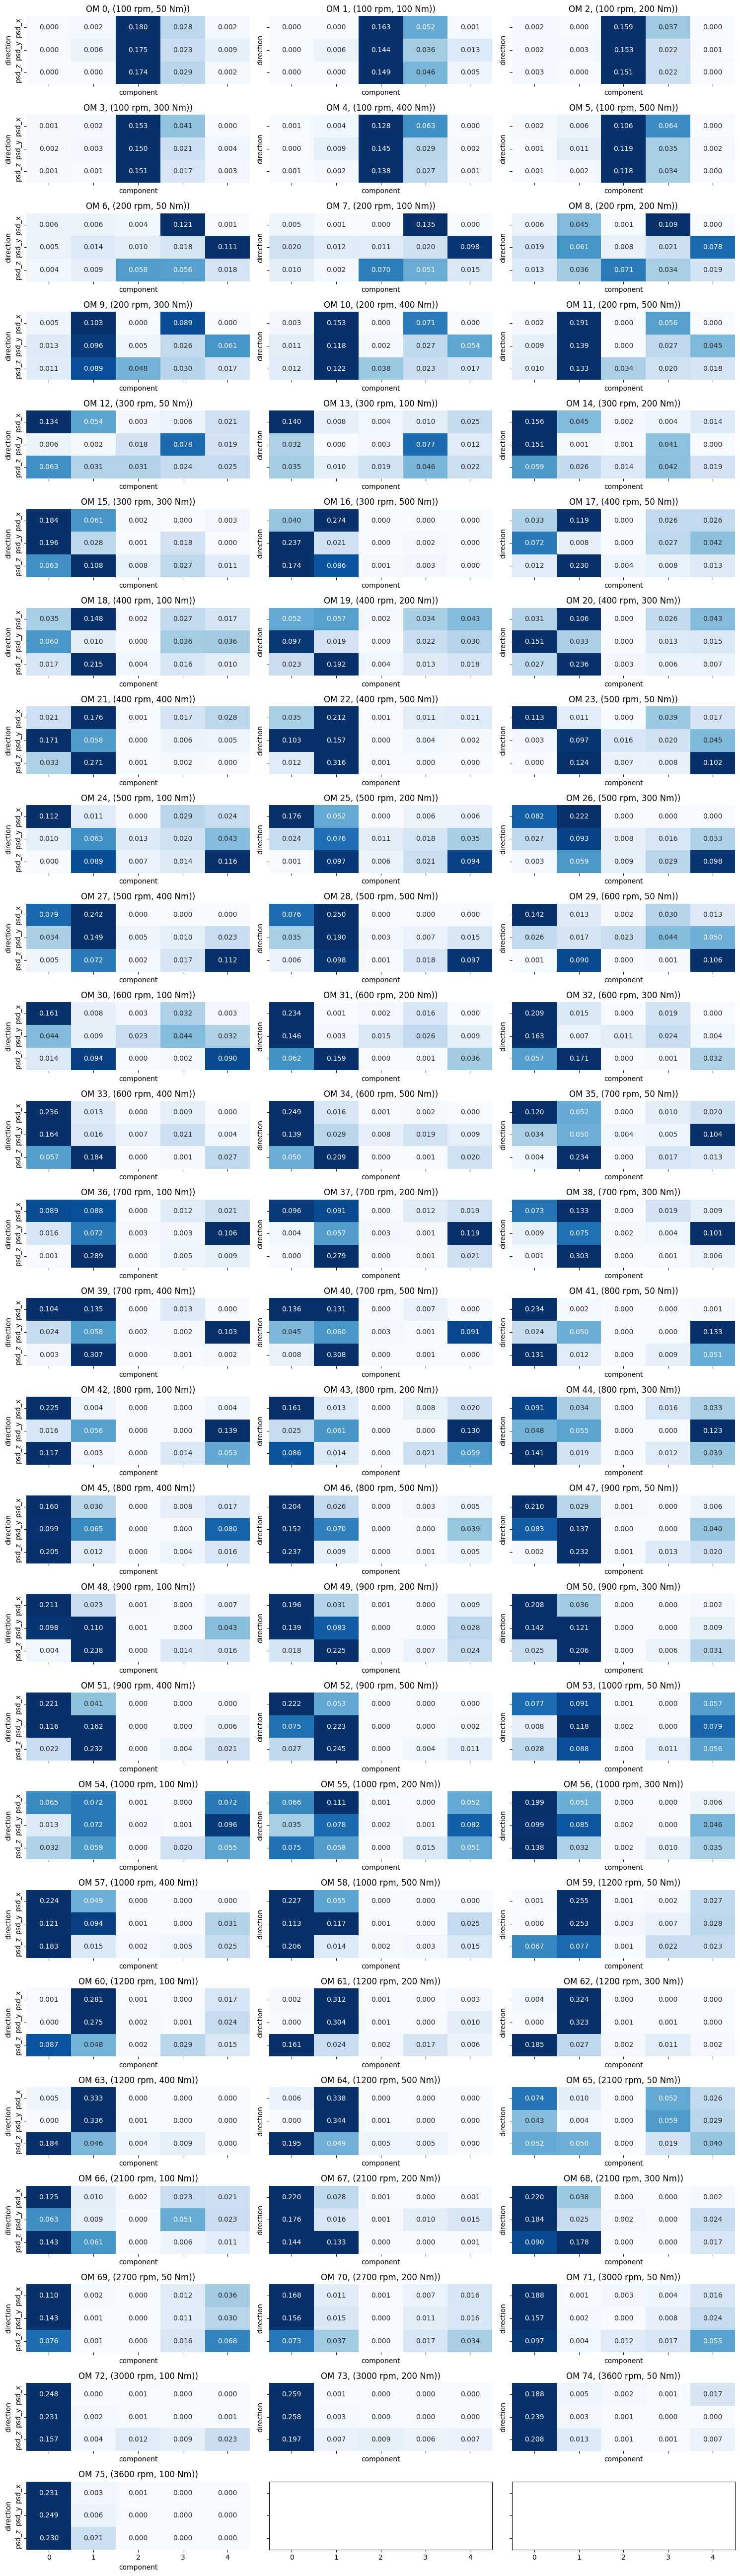

In [9]:
SHOW_FINGERPRINTS = True   # set SHOW_FINGERPRINTS to False, if visualization should not be shown

# for each unique combination of RPM and torque, assign a unique cluster label

df_W_train_with_OM['cluster_label_unique'] = df_W_train_with_OM.groupby(['rotational speed [RPM]', 'torque [Nm]']).ngroup()
cluster_label_unique_name_mapping = df_W_train_with_OM.groupby('cluster_label_unique').first()[['rotational speed [RPM]', 'torque [Nm]']].reset_index()

# extract operating mode wise fingerprints
grouping_vars = ['direction', 'cluster_label_unique']
df_ = df_W_train_with_OM[COMPONENT_COLUMNS + grouping_vars].copy()
fingerprints = {
    om: om_group.groupby(['direction']).mean().drop(columns=['cluster_label_unique']) for om, om_group in df_.groupby('cluster_label_unique')
}


# illustrate fingerprints
if SHOW_FINGERPRINTS:
    nrows = math.ceil(len(fingerprints) / 3)
    fig, axes = plt.subplots(figsize=(15, 2*nrows), nrows=nrows, ncols=3, sharex=True, sharey=True)
    for om, ax in tqdm(zip(fingerprints, axes.flat), total=len(fingerprints), desc='Plotting fingerprints'):
        om_group = fingerprints[om]
        om_group.columns = om_group.columns.astype(str)
        sns.heatmap(om_group, annot=True, fmt=".3f", ax=ax, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
        rpm = cluster_label_unique_name_mapping[cluster_label_unique_name_mapping.cluster_label_unique == om]['rotational speed [RPM]'].values[0]
        Nm = cluster_label_unique_name_mapping[cluster_label_unique_name_mapping.cluster_label_unique == om]['torque [Nm]'].values[0]
        ax.set_title(f'OM {om}, ({rpm} rpm, {Nm} Nm))')
        ax.set_xlabel('component')
    fig.tight_layout()

---

# Additional exploration

What follows in here can be seen as additional exploration. 
It is not necessary to understand the anomaly detection work flow.

## Similarity between fingerprints

Below, we visualize the pairwise distance between the fingerprints. We observe that the fingerprints are very similar in some cases, when the operating conditions are similar. For instance, fingerprints 0-4 are similar, as they express the vibrations at 100 rpm.

Text(0.5, 1.0, 'Cosine distance between fingerpints')

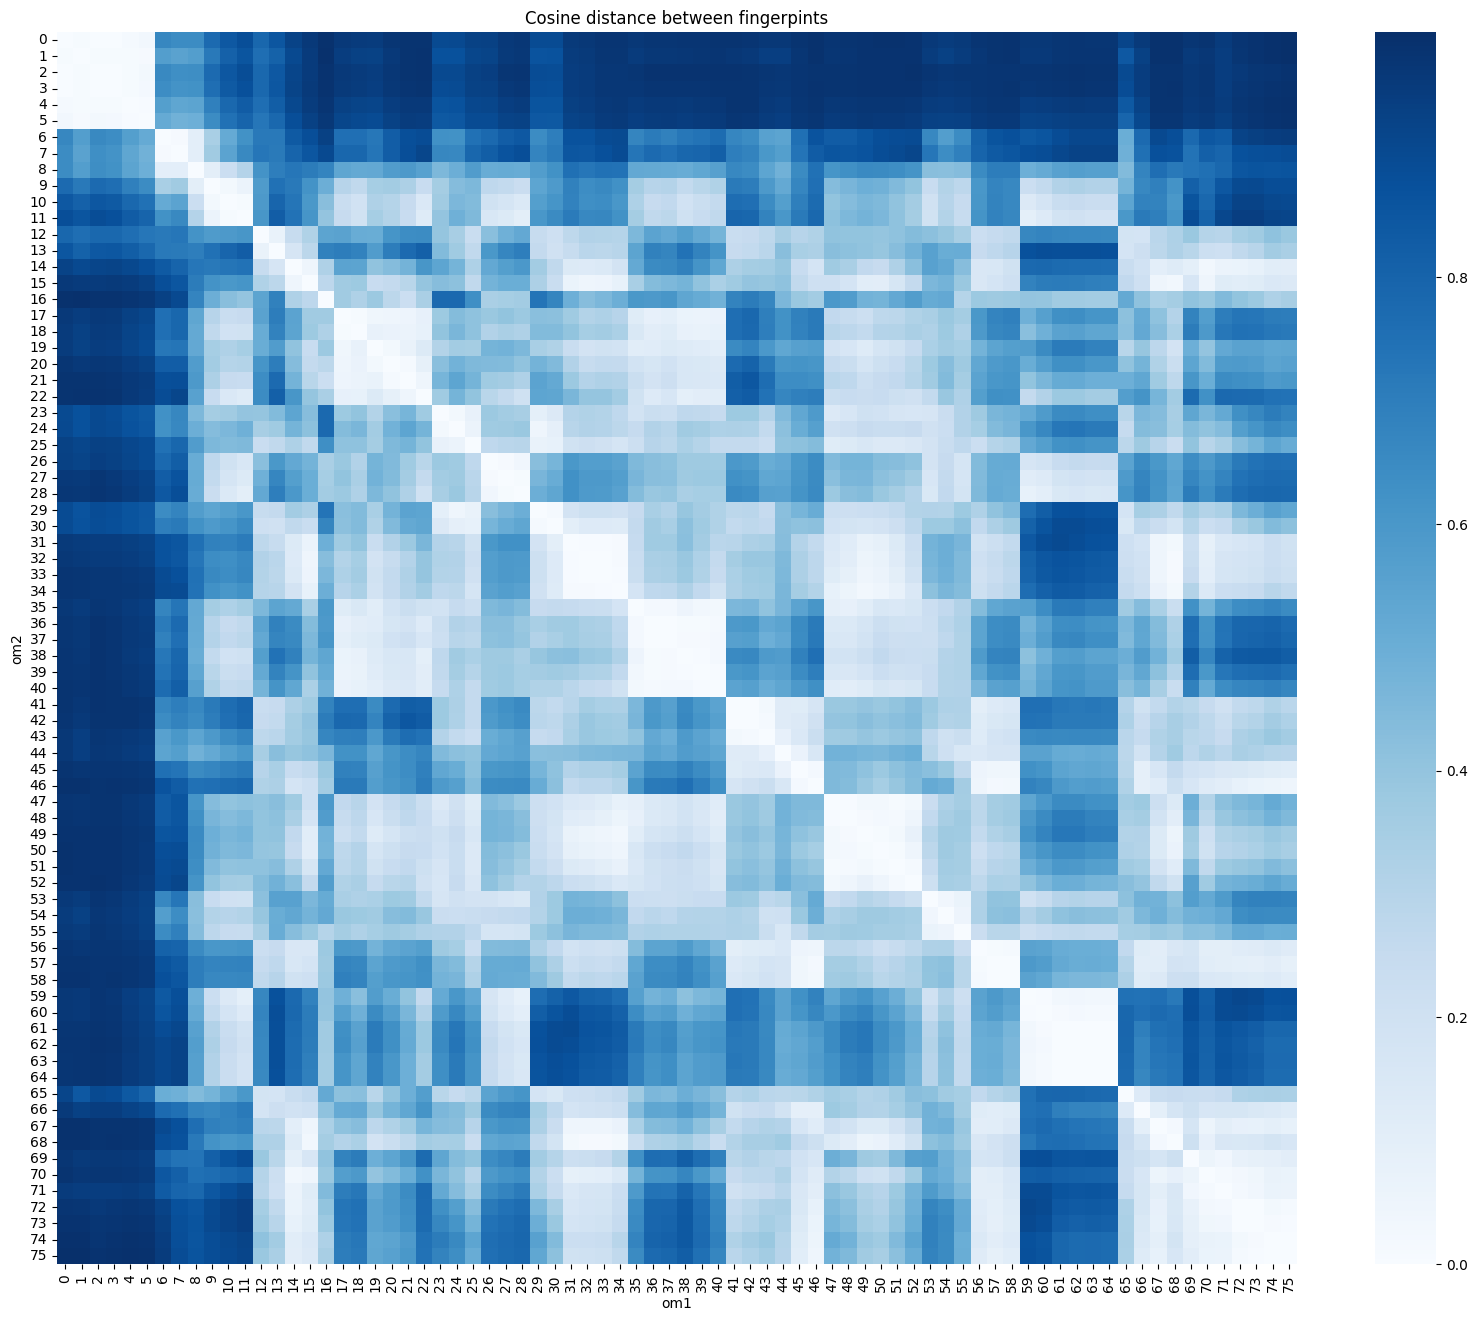

In [10]:
pairwise_distances = []
for om1 in fingerprints:
    fp1 = fingerprints[om1]
    for om2 in fingerprints:
        fp2 = fingerprints[om2]
        dist_ = distance_metrics.cosine_distance(fp1, fp2)
        pairwise_distances.append({'om1': om1, 'om2': om2, 'dist': dist_})
df_pairwise_dist = pd.DataFrame(pairwise_distances)

df_plot = df_pairwise_dist.pivot(columns="om1", index="om2", values="dist")
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(df_plot, ax=ax, cmap='Blues', annot=False, fmt=".2f")
ax.set_title(f"Cosine distance between fingerpints")

## Constructing consensus fingerprints

A possible extension of our approach is to utilize consensus fingerprints.
Consensus fingerprints are constructed by summarizing similar fingerprints by clustering.
This idea was not used in the anomaly detection work flow, but is presented here for completeness.

Below we show the dendrograms for clustering the fingerprints using hierarchical clustering with 4 different linkage methods. The dendrograms illustrate how the fingerprints are clustered based on their similarity. The fingerprints are clustered based on the cosine distance between the fingerprints.

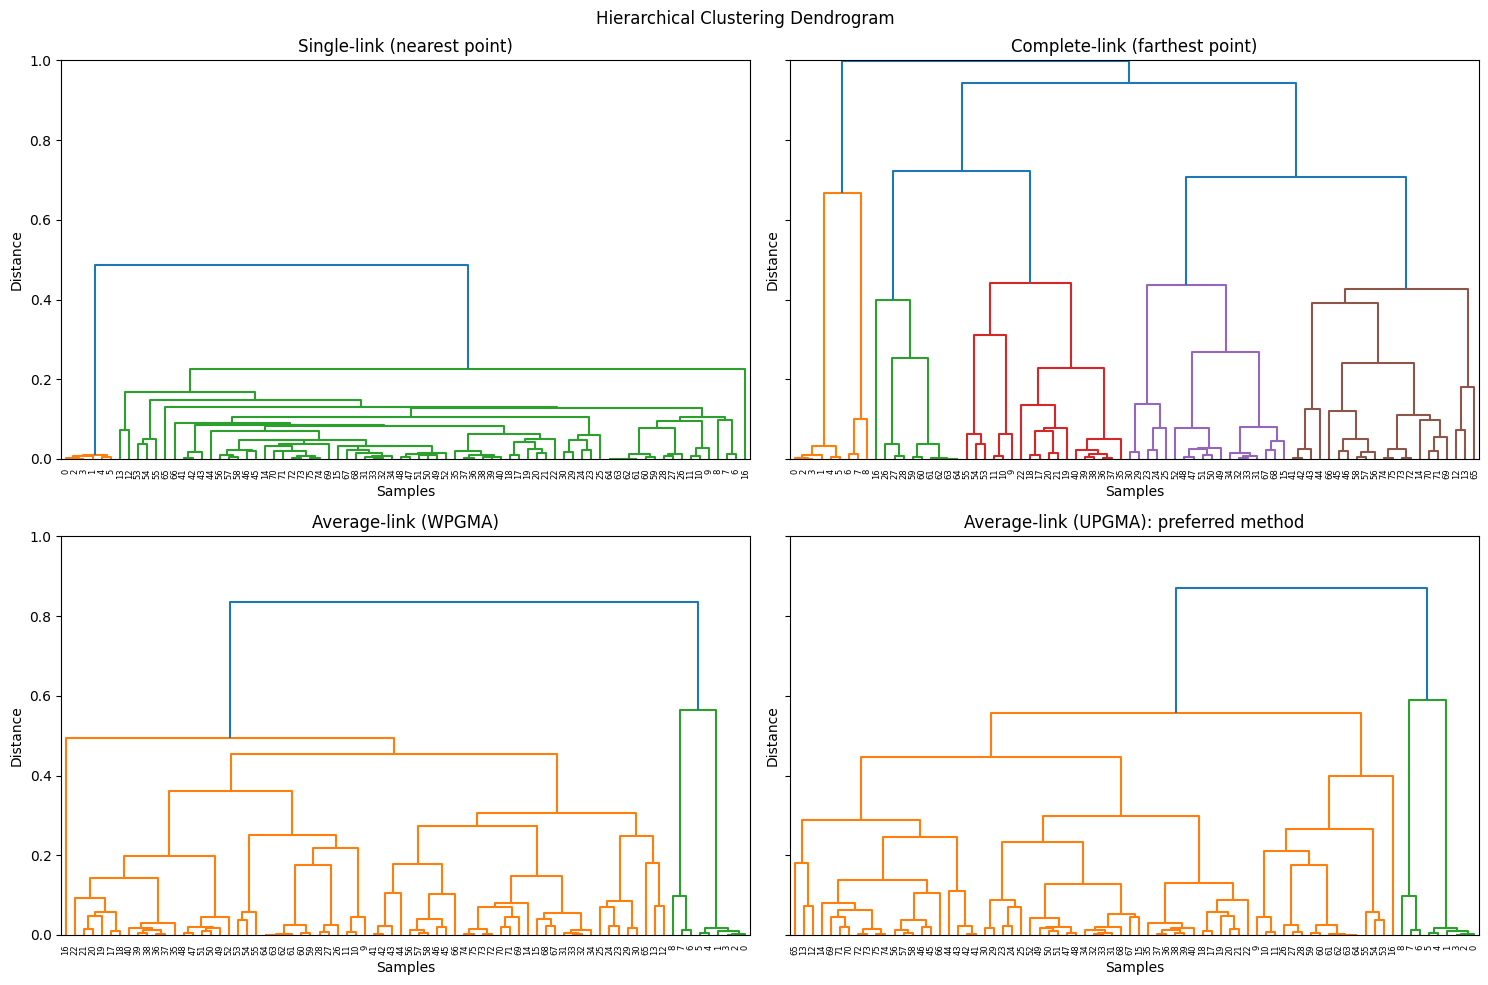

In [11]:
def plot_dendrogram(linkage_matrix, ax=None, **kwargs):
    dendrogram(linkage_matrix, ax=ax, **kwargs)
    ax.set_title('Hierarchical Clustering Dendrogram')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Distance')
    return ax

fingerprints_feature_space = np.vstack(pd.Series(fingerprints).apply(lambda df: df.stack().values).to_numpy())

fig, axes = plt.subplots(figsize=(15, 10), ncols=2, nrows=2, sharey=True)
axes = axes.flatten()
fig.suptitle('Hierarchical Clustering Dendrogram')

# Single linkage clustering
linkage_matrix_avg = linkage(pdist(fingerprints_feature_space, metric='cosine'), optimal_ordering=True, method='single')
ax = plot_dendrogram(linkage_matrix_avg, ax=axes[0])
ax.set_title('Single-link (nearest point)')

# Complete linkage clustering
linkage_matrix_ward = linkage(pdist(fingerprints_feature_space, metric='cosine'), optimal_ordering=True, method='complete')
ax = plot_dendrogram(linkage_matrix_ward, ax=axes[1])
ax.set_title('Complete-link (farthest point)')

# Average linkage clustering: WPGMA
linkage_matrix_avg = linkage(pdist(fingerprints_feature_space, metric='cosine'), optimal_ordering=True, method='weighted')
ax = plot_dendrogram(linkage_matrix_avg, ax=axes[2])
ax.set_title('Average-link (WPGMA)')

# Average linkage clustering: UPGMA
linkage_matrix_avg = linkage(pdist(fingerprints_feature_space, metric='cosine'), optimal_ordering=True, method='average')
ax = plot_dendrogram(linkage_matrix_avg, ax=axes[3])
ax.set_ylim(0, 1)
ax.set_title('Average-link (UPGMA): preferred method')

fig.tight_layout()

For instance, if we choose the average linkage method, we can see that the fingerprints are clustered into 4 clusters using a threshold of 0.5.

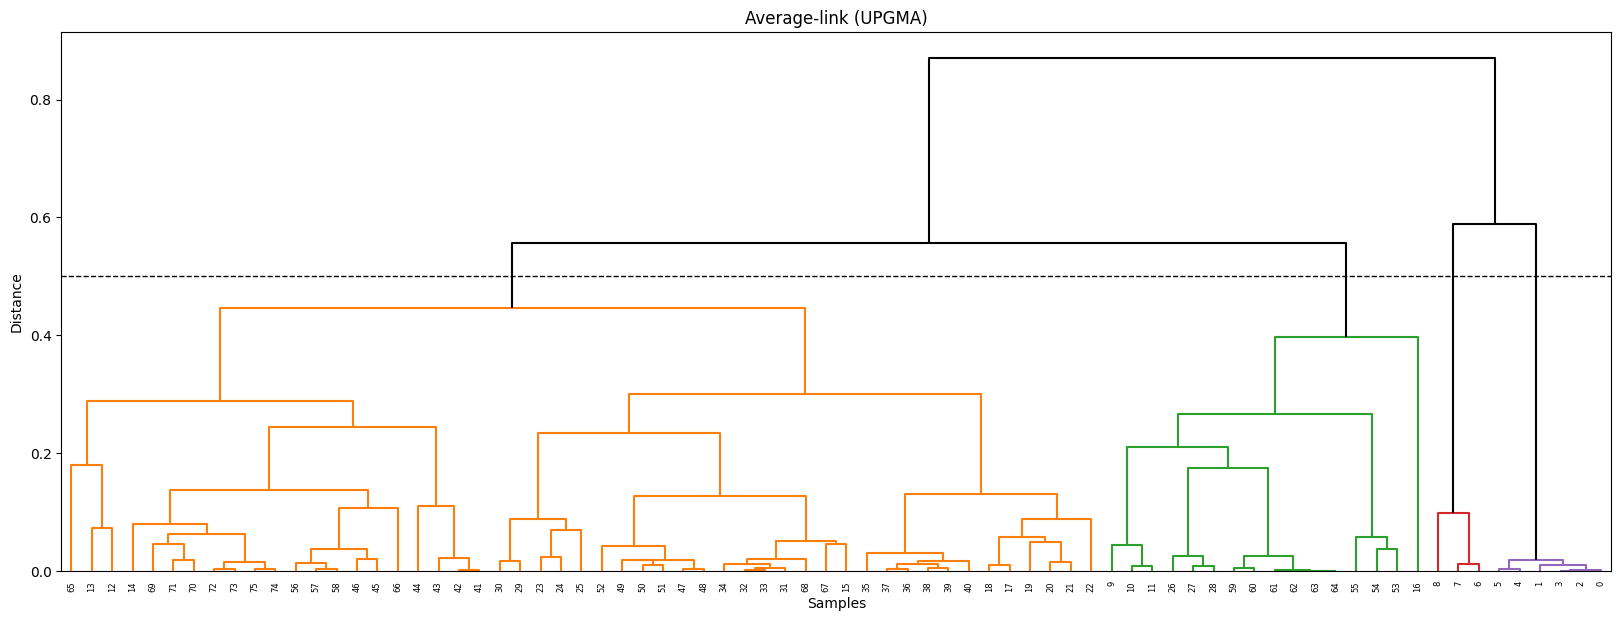

In [12]:
# Set a threshold to determine the number of clusters (you can adjust this threshold as needed)
threshold = 0.5

linkage_matrix_avg = linkage(pdist(fingerprints_feature_space, metric='cosine'), optimal_ordering=True, method='average')
fig, ax = plt.subplots(figsize=(20, 7))
ax = plot_dendrogram(linkage_matrix_avg, ax=ax, color_threshold=threshold, above_threshold_color='k')
ax.set_title('Average-link (UPGMA)')
ax.axhline(y=threshold, c='k', ls='--', lw=1)

# Get the cluster labels based on the threshold
cluster_labels = fcluster(linkage_matrix_avg, threshold, criterion='distance')
# generate dictionary where each operating mode is mapped to the respective group and save locally
cluster_labels_dict = dict(zip(list(string.ascii_uppercase[0:len(cluster_labels)]), cluster_labels))
#if CACHE_RESULTS:
if False:
    with open('cluster_labels_dict.pickle', 'wb') as fp:
        pickle.dump(cluster_labels_dict, fp)

A possible clustering of the fingerprints is shown below.
Each row is a fingerprint and each column is a component of the fingerprint (over all three directions).
For instance, the fingerprints 0-4 which were previously shown to be very similar, as they all express vibrations at 100 rpm, would be clustered together.

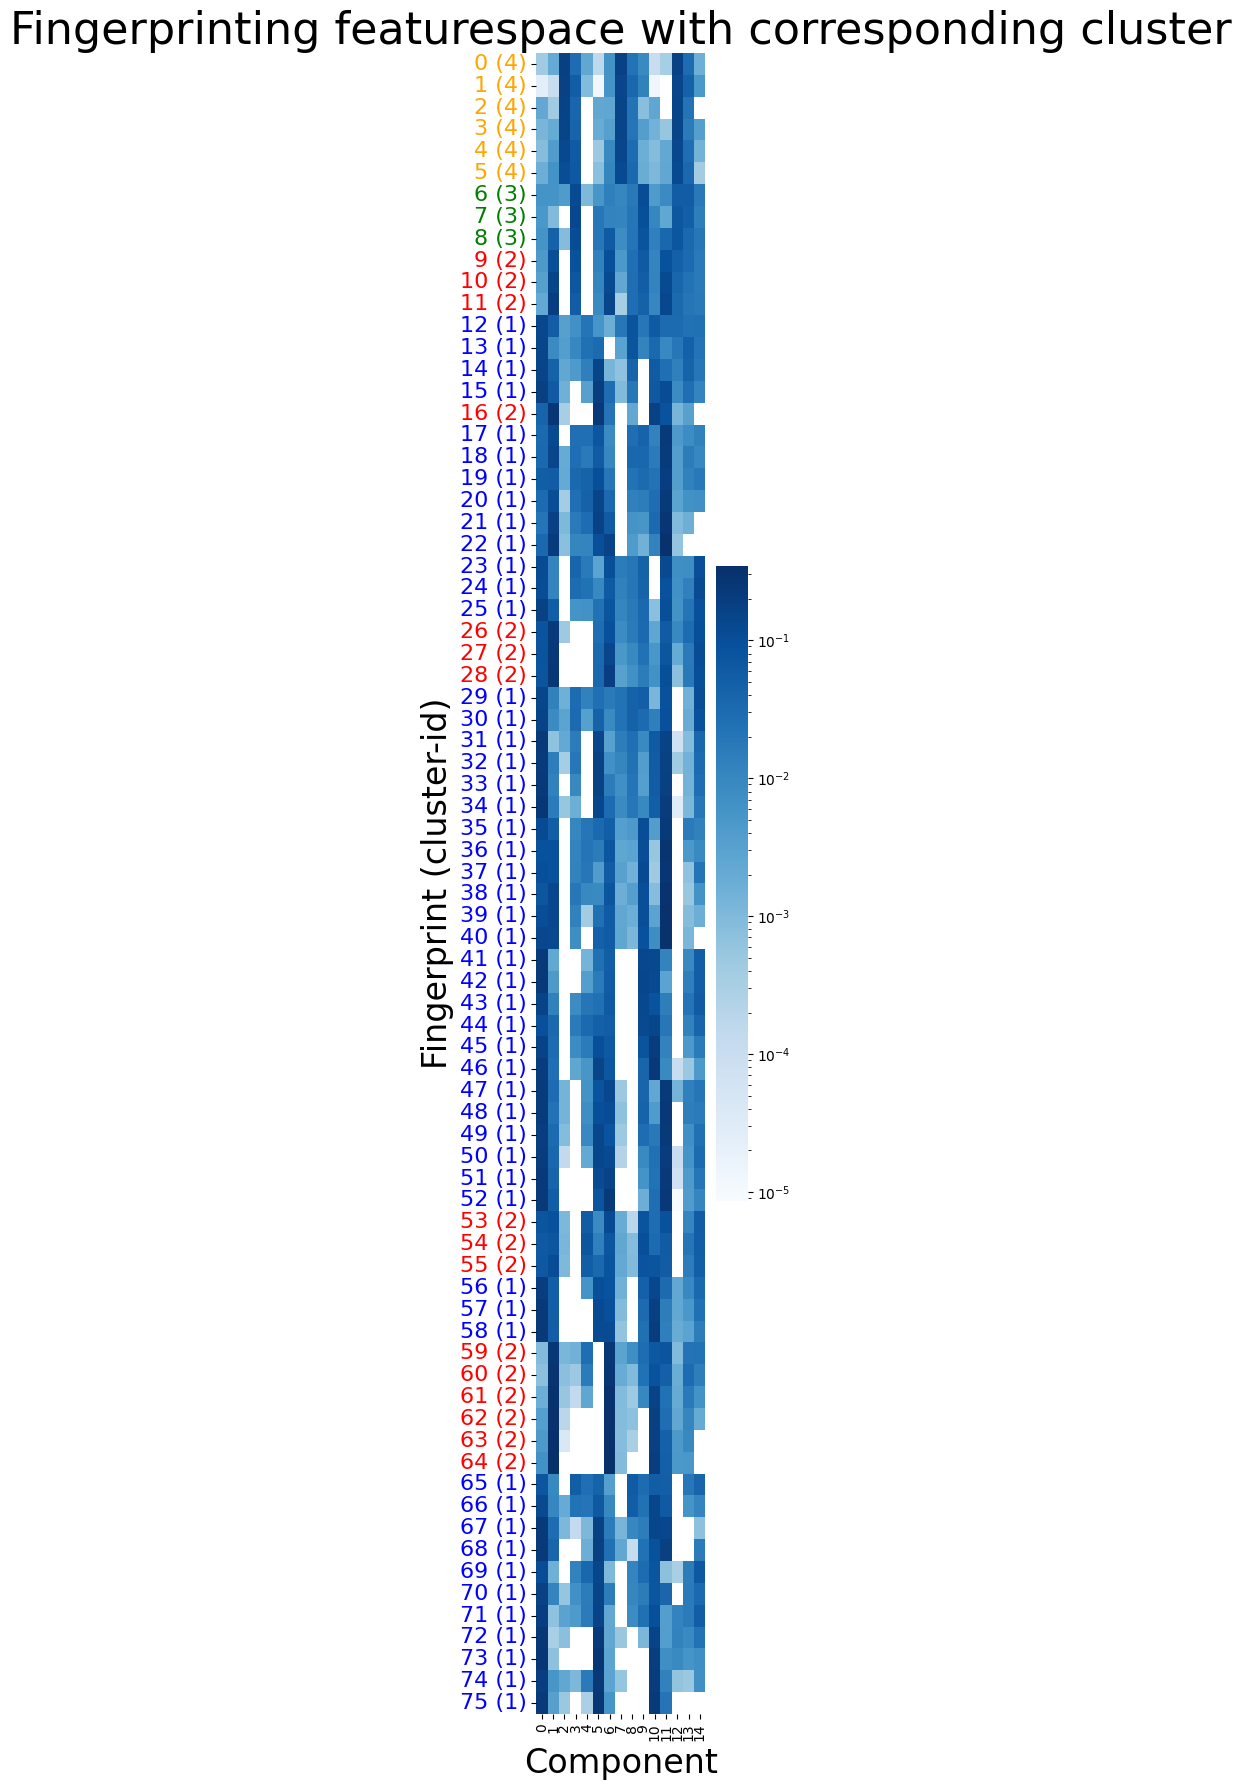

In [13]:
tick_color = {1: 'blue', 2: 'red', 3: 'green', 4: 'orange', 5: 'purple', 6: 'brown', 7: 'pink', 8: 'gray', 9: 'olive', 10: 'cyan'}

dfs_ = {om: fingerprints[om].values.flatten() for om in fingerprints}
fig, ax = plt.subplots(figsize=(4, 18))
ax.set_title('Fingerprinting featurespace with corresponding cluster', fontsize=32)

df = pd.DataFrame(dfs_).T
sns.heatmap(df, ax=ax, cmap='Blues', annot=False, fmt=".2f", norm=LogNorm())
texts = []
for tick, cluster_label_ in zip(ax.get_yticklabels(), cluster_labels):
    tick.set_color(tick_color[cluster_label_])
    texts.append(f'{tick.get_text()} ({cluster_label_})')
ax.set_xlabel('Component', fontsize=24)
ax.set_ylabel('Fingerprint (cluster-id)', fontsize=24)
ax.set_yticklabels(texts, rotation=0, fontsize=16);
fig.tight_layout()

# Online anomaly detection

# Loading and preprocessing test data

In order to create a balanced test set, we first load the process and vibration data of the test set that exhibit a high level of pitting and merge it with the healthy data which was not used in the training set.

The test data consists of two different conditions:
1. **Anomaly condition**: Pitting level 1-8. For each level of pitting, there are between 267 and 304 samples in the test set that were recorded at different speeds and torques.
2. **Normal condition**: Healthy data

The test data is preprocessed in the same way as the training data, including
1. Conversion from time to frequency domain
2. Order transformation and binning
3. Frequency-band normalization

As these steps were all already explained in the [previous notebook on data preprocessing](02_data_processing.ipynb), we will not further go into detail again.
The cell below preprocesses the test data in the same way.
As a result, two lists of dataframes are constructed: 
1. `df_orders_test_folds`, where each dataframe contains the frequency transformed measurements, 
2. `meta_data_test_folds`, where each dataframe contains the process data and some additional information on the measurements.
An excerpt is shown below or the first fold.

In [ ]:
recompute = False
df_orders_test, meta_data_test = get_and_preprocess_unhealthy_data(df_data_healthy_test, f, recompute=recompute)

 26%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 78/296 [00:06<00:18, 11.97it/s]

# Derive vibration weights

After the vibration data of the test set was preprocessed in the same way as the training data, the weight matrix $\mathbf{W}$ is extracted in this section.
In the subsequent anomaly detection, $\mathbf{W}$ will be compared to the context-sensitive fingerprint of the same operating mode.
The cell below calculates the weight matrices for the test data.

In [ ]:
# extract df_W_offline and df_W_online
def extract_vibration_weights_per_measurement_period(measurement_periods, col_names, band_cols, normalization, model, verbose=False):
    Ws = []
    for period in tqdm(measurement_periods, disable=not verbose, desc='Extracting vibration weights per measurement period'):
        assert len(period) == 3, 'should have exactly 3 directions per measurement period'
        band_column_names = period.columns[period.columns.str.contains('band_')]
        V = period.set_index(['direction'])[band_column_names]  # already normalized
        W = model.nmf.transform(V.to_numpy())
        W = pd.DataFrame(W, columns=col_names)
        Ws.append({
            'unique_sample_id': period.unique_sample_id.unique()[0],
            'V_normalized': V,
            'W': W
        })
    return pd.DataFrame(Ws)

# extract train vibration measurement periods

df_V_train[['unique_sample_id', 'direction']] = meta_data_train[['unique_sample_id', 'direction']]
train_vibration_measurement_periods = []
for sample_id, group in df_V_train.groupby('unique_sample_id'):
    measurement_period = {
        'start': 'unknown', 
        'stop': 'unknown',
        'group': group,
        'sample_id': sample_id,
    }
    train_vibration_measurement_periods.append(group)

# extract test vibration measurement periods


df_V_test_normalized = normalize_1(df_orders_test, BAND_COLS)
df_ = df_V_test_normalized
df_[['sample_id', 'unique_sample_id', 'direction']] = meta_data_test[['sample_id', 'unique_sample_id', 'direction']]
test_vibration_measurement_periods = []
test_vibration_measurement_periods_meta_data = []
n_index_errors = 0
for unique_sample_id, group in df_.groupby('unique_sample_id'):
    rpm = meta_data_test[meta_data_test['unique_sample_id'] == unique_sample_id]['rotational speed [RPM]'].unique()[0]
    torque = meta_data_test[meta_data_test['unique_sample_id'] == unique_sample_id]['torque [Nm]'].unique()[0]
    try:
        om = cluster_label_unique_name_mapping[
            (cluster_label_unique_name_mapping['rotational speed [RPM]'] == rpm) & 
            (cluster_label_unique_name_mapping['torque [Nm]'] == torque)
        ]['cluster_label_unique'].iloc[0]
    except IndexError:
        n_index_errors += 1
        om = -1
    measurement_period = {
        'start': 'unknown', 
        'stop': 'unknown',
        'group': group,
        'unique_sample_id': unique_sample_id,
        'rpm': rpm,
        'torque': torque,
        'unique_cluster_label': om
    }
    test_vibration_measurement_periods.append(group)
    test_vibration_measurement_periods_meta_data.append(measurement_period)
    
n_total = len(test_vibration_measurement_periods)

    
df_W_offline = extract_vibration_weights_per_measurement_period(train_vibration_measurement_periods, fingerprints[0].columns, BAND_COLS, normalize_1, model)
df_W_online = extract_vibration_weights_per_measurement_period(test_vibration_measurement_periods, fingerprints[0].columns, BAND_COLS, normalize_1, model)

df_W_online.head()

We illustrate the derived weights for a single measurements below. The format of the weights is the same as of the fingerprint shown in the previous section.

In [ ]:
N_COMPONENTS = 5
period = 10

usid = df_W_online['unique_sample_id'][period]
df_ = meta_data_test[meta_data_test['unique_sample_id']==usid]
rpm = df_['rotational speed [RPM]'].iloc[0]
torque = df_['torque [Nm]'].iloc[0]

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(df_W_online['W'][period], annot=True, fmt=".6f", ax=ax, cmap='Blues', vmin=0, vmax=0.05, cbar=False)
ax.set_title(f'Derived weights for measurement {period} @ {rpm} rpm, {torque} Nm');
ax.set_yticklabels(['x', 'y', 'z'], rotation=0)
ax.set_ylabel('Measurement direction')
ax.set_xlabel('Component');

# Anomaly detection 

Because the measurements are not timestamped, it is not possible to order the measurements in time and calculate a cumulative anomaly score.
Therefore, we perform only the measurement-wise anomaly detection in this section.

## Distance to fingerprints

Per operating mode, we calculate the distances of the derived weights to the corresponding fingerprint below.

In [ ]:
# cell takes around 60 minutes to run (!) --> going to cache the results
SHOW_DISTANCES = False

def calculate_distances_per_measurement_period(measurement_period, fingerprints, verbose=False):
    # pointwise Mahalanobis distance
    fingerprint_matrix = np.array([fingerprints[om].to_numpy().flatten() for om in fingerprints])
    # calculate covariance matrix
    fingerprint_S = np.cov(fingerprint_matrix.T)
    # calculate inverse
    fingerprint_SI = np.linalg.inv(fingerprint_S)
    # calculate mu
    fingerprint_mu = fingerprint_matrix.mean(axis=0)
    df_dist_ = []
    for idx, row in tqdm(measurement_period.iterrows(), total=len(measurement_period), disable=not verbose):
        for om in fingerprints:
            weights = row['W']
            fingerprint = fingerprints[om]
            tmp = {
                'idx': idx,
                'data': row, 
                'om': om, 
                #'frobenius_norm': distance_metrics.frobenius_norm(weights, fingerprint),
                #'frobenius_norm_pow2': distance_metrics.frobenius_norm_v2(weights, fingerprint),
                #'frobenius_norm_sqrt': distance_metrics.frobenius_norm_v3(weights, fingerprint),
                'cosine_distance': distance_metrics.cosine_distance(weights, fingerprint),
                'manhattan_distance': distance_metrics.manhattan_distance(weights, fingerprint),
            }
            df_dist_.append(tmp)
    df_dist_ = pd.DataFrame(df_dist_)
    return df_dist_

# calculate/load distances
fpath_offline = os.path.join(FPATH_DISTANCES, f'df_dist_offline.pkl')
os.makedirs(os.path.dirname(fpath_offline), exist_ok=True)
fpath_online = os.path.join(FPATH_DISTANCES, f'df_dist_online.pkl')
os.makedirs(os.path.dirname(fpath_online), exist_ok=True)
if os.path.exists(fpath_offline) and os.path.exists(fpath_online):
    # load cached distances
    df_dist_offline = pickle.load(open(fpath_offline, 'rb'))
    df_dist_online = pickle.load(open(fpath_online, 'rb'))
else:
    # calculate distances and cache results
    df_dist_offline = calculate_distances_per_measurement_period(df_W_offline, fingerprints=fingerprints)
    pickle.dump(df_dist_offline, open(fpath_offline, 'wb'))
    df_dist_online = calculate_distances_per_measurement_period(df_W_online, fingerprints=fingerprints)
    pickle.dump(df_dist_online, open(fpath_online, 'wb'))


# pivot cosine distance:
# for each measurement period (row), get the distance to each operating mode (column)
df_cosine = df_dist_online[['idx', 'om', 'cosine_distance']].pivot(index='idx', columns='om', values='cosine_distance')
# assign the corresponding operating mode to the given row (if known), else, assign -1
df_cosine[['rpm', 'torque', 'unique_cluster_label']] = pd.DataFrame(test_vibration_measurement_periods_meta_data)[['rpm', 'torque', 'unique_cluster_label']]

g = sns.displot(data=df_dist_offline, 
                x="cosine_distance", col="om", col_wrap=10, height=1, aspect=2, bins=20, kind="hist")

We choose the cosine distance as appropriate metric.
Below, we create a pivot table of the cosine distance and compare distances between measurements and their corresponding fingerprints (left) and other fingerprints (right).

In [ ]:
distance_to_own_cluster_center = []
for idx, row in df_cosine.iterrows():
    om = row['unique_cluster_label']
    if om != -1:
        distance_to_own_cluster_center.append(row[om])
    else:
        distance_to_own_cluster_center.append(np.nan)
df_cosine['distance_to_own_cluster_center'] = distance_to_own_cluster_center
df_cosine['pitting'] = df_W_online['unique_sample_id'].str.contains(f'pitting_level_')
df_cosine['pitting_level'] = df_W_online['unique_sample_id'].str.extract(r'pitting_level_(\d)')
df_cosine['pitting_level'] = df_cosine['pitting_level'].fillna(0).astype(int)

print('Pivot table with distances to all fingerprints (0 - 72), corresponding rpm and torque values, and additional information on the anomaly condition:')
display(df_cosine.head())

fig, axes = plt.subplots(figsize=(16, 8), ncols=2)

ax = df_cosine['distance_to_own_cluster_center'].plot(kind='hist', bins=20, ax=axes[0], alpha=0.5, legend=False)
ax.set_title('Distance to own cluster centers')
ax.set_xlabel('Cosine distance')

# plot distance to other cluster centers
ax = df_cosine.drop(columns=['rpm', 'torque', 'unique_cluster_label', 'distance_to_own_cluster_center', 'pitting', 'pitting_level']).melt()['value'].plot(kind='hist', bins=20, ax=axes[1], alpha=0.5, legend=False)
ax.set_title('Distance to other cluster centers')
ax.set_xlabel('Cosine distance');

The cosine distance to the context-sensitive fingerprint is typically higher, when pitting is present.
This is expected, as the context-sensitive fingerprint is derived from healthy data without pitting and data with pitting is likely to have vibration patterns not present in the healthy data set.

In [ ]:
ax = sns.boxplot(data=df_cosine, y='distance_to_own_cluster_center', x='pitting_level')
ax.set_ylabel('Distance to context sensitive fingerprint')
ax.set_title(f'Distance to own cluster center per pitting level');

## ROC-curves

Whether a datapoint is labelled as anomalous depends on a predefined distance threshold.
In this section, we caclulate ROC-curves by varying this distance threshold.

An ROC-curve is calculated per fold. Below, we visualize the ROC curve for the first fold.
It can be observed that the anomaly detection generally performs well with a area under the curve (AUC) of $0.962$.
Operators aim for a high true positive rate (TPR) while minimizing false alarms (keeping the false positive rate (FPR) low). We track the TPR at a stable FPR of 0.1 (TPR@FPR=0.1), which represents the TPR when there are 10% false positives. In this scenario, the TPR is 97%.

In [ ]:
threshold = 0.1

df_cosine = df_cosine[df_cosine.unique_cluster_label != -1]  # removed unknown cluster labels

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the general ROC curve
fpr, tpr, roc_auc = calculate_roc_characteristics(df_cosine)
tpr_at_fpr = calc_tpr_at_fpr_threshold(tpr, fpr, threshold=threshold)
ax.plot(fpr, tpr, color='blue', lw=4, label=f'overall (area = {roc_auc:.3f})', alpha=0.66)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
ax.plot([0, threshold], [tpr_at_fpr, tpr_at_fpr], color='red', lw=2, linestyle='--', label=f'TPR@FPR={threshold:.2f} = {tpr_at_fpr:.2f}')
ax.plot([threshold, threshold], [0, tpr_at_fpr], color='red', lw=2, linestyle='--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve')
n_total = len(df_cosine)
n_healthy = len(df_cosine[df_cosine['pitting'] == False])
n_unhealthy = len(df_cosine[df_cosine['pitting'] == True])
text = f"n={n_total} ({n_healthy} healthy, {n_unhealthy} unhealthy)"
ax.annotate(xy=(0.1, 0.025), text=text)

ax.legend(loc='lower right', title='Pitting severity level');

An alternatve objective criterium is to keep the FPR as low as possible at a high TPR.
The plot below illustrates the FPR@TPR=0.1. In the shown fold, FPR@TPR=0.1 is 0.07.

In [ ]:

df_cosine = df_cosine[df_cosine.unique_cluster_label != -1]  # removed unknown cluster labels

fig, ax = plt.subplots(figsize=(8, 6))

threshold = 0.90

# Plot the general ROC curve
fpr, tpr, roc_auc = calculate_roc_characteristics(df_cosine)
fpr_at_tpr = calc_fpr_at_tpr_threshold(tpr, fpr, threshold=threshold)
ax.plot(fpr, tpr, color='blue', lw=4, label=f'overall (area = {roc_auc:.3f})', alpha=0.66)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
ax.plot([fpr_at_tpr, fpr_at_tpr], [0, threshold], color='green', lw=2, linestyle='--', label=f'FPR@TPR={threshold:.2f} = {fpr_at_tpr:.2f}')
ax.plot([0, fpr_at_tpr], [threshold, threshold], color='green', lw=2, linestyle='--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve')
n_total = len(df_cosine)
n_healthy = len(df_cosine[df_cosine['pitting'] == False])
n_unhealthy = len(df_cosine[df_cosine['pitting'] == True])
text = f"n={n_total} ({n_healthy} healthy, {n_unhealthy} unhealthy)"
ax.annotate(xy=(0.1, 0.025), text=text)

ax.legend(loc='lower right', title='Pitting severity level');

# Conclusion

In this notebook we illustrated our contextual anomaly detection method on the example of a gearbox that is subject to pitting.
We illustrated how to construct context-sensitive fingerprints and how to utilize the fingerprints for anomaly detection.
We showed that our method is capable to detect anomalies in the test set while keeping the amount of false positives low.
In a real-world setting, additional steps have to be taken to estimate the underlying operating mode.

©, 2023, Sirris